In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import requests
import tempfile
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1
from functools import partialmethod
import pymysql
import lifetimes
from lifetimes import ParetoNBDFitter

In [2]:
media_dict = {'fb':'facebook_ads','google':'googleadwords_int', 'restricted':'restricted', 
              'unity':'unityads_int', 'applovin':'applovin_int', 'organic':'organic'}

def data_exract():
    client = bigquery.Client.from_service_account_json('./creds_coloring.json')
    bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
    bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./creds_coloring.json')
    project_id = 'goingtoclouds'
    
    print('Loading all data with transactions from bigquery...')
    sql = '''
    SELECT transaction_date, user_id, SUM(revenue) as sales, platform, placement 
    FROM (
      SELECT date as transaction_date, user_id, platform, sum(revenue) as revenue, placement 
      FROM `goingtoclouds.applovin_max.new_max_user_revenue`  
      GROUP BY date, user_id, platform, placement 
    
      UNION ALL
      SELECT date as transaction_date, user_id, 'ios' as platform, sum(revenue) as revenue, placement 
      FROM `goingtoclouds.ironsource_happy_canvas.ironsource_revenue` 
      GROUP BY date, user_id, platform, placement)
    GROUP BY transaction_date, user_id, platform, placement  
    '''
    transactions_dt  = client.query(sql, project=project_id).to_dataframe()
    
    print('Connecting to mysql for iaps extraction...')
    conn = pymysql.connect(user='a.nosko',
                           password='38%gZyE@qudw',
                           host='hc-prod-rds3.cwydukect5ey.us-east-1.rds.amazonaws.com',
                           database='hc_prod')
    cursor = conn.cursor()
    sql = '''
    select transaction_date, user_id, sum(sales) as sales 
    from 
    ( SELECT DATE(purchaseDate) as transaction_date, memberId as user_id, 9.99*0.65 as sales
    FROM hc_prod.InAppPurchase iap 
    WHERE cost is not NULL
    union all 
    SELECT DATE(purchaseTime) as transaction_date, memberId as user_id, 9.99*0.65 as sales
    FROM hc_prod.AndroidPurchase ap 
    WHERE cost is not NULL) all_data
    group by transaction_date, user_id'''
    cursor.execute(sql)
    iaps = cursor.fetchall()
    conn.close()
    
    iaps_dt = pd.DataFrame(iaps, columns=['transaction_date', 'user_id', 'sales'])
    iaps_dt['placement'] = 'iaps'
    
    # extract ids of users who have iaps
    without_iap = transactions_dt[~transactions_dt.user_id.isin(iaps_dt.user_id.tolist())]
    
    training_dt = pd.concat([without_iap, 
                             transactions_dt[transactions_dt.user_id.isin(iaps_dt.user_id.tolist()) & 
                                             (transactions_dt['placement'].isin(['undo', 'nextDayPicture', 'floatingUndo', 
                                                                                 'showCPRV', 'FloatingHint']))]])
    # bind transactions with iaps
    transactions_dt = pd.concat([transactions_dt, iaps_dt])
    
    # replace zeros in datasets
    transactions_dt.sales.replace(0, 0.0000001, inplace=True)
    transactions_dt['sales'] = transactions_dt['sales'].astype(float)
    training_dt.sales.replace(0, 0.0000001, inplace=True)
    
    print("Grouping data by user_id and transaction_date...")
    transactions_dt = transactions_dt.groupby(["transaction_date", "user_id"]).sales.sum().reset_index()
    training_dt = training_dt.groupby(["transaction_date", "user_id"]).sales.sum().reset_index()
    
    # print("Extracting media source for all user_ids...") 
    sql = '''
    select *,  
    ifnull(LEAD(first_cohort_date) OVER (PARTITION BY user_id ORDER BY first_cohort_date), current_date()+1) AS uninstall_date 
    from (
        select distinct appsflyer_id, ifnull(customer_user_id, 0) as user_id, platform,
            ifnull(replace(lower(media_source), ' ', '_'), 'organic') as media_source, 
            install_day as first_cohort_date
        from `goingtoclouds.aggregated_data.aggregated_installs_v3`)
    '''
    media_sources_dt = client.query(sql, project=project_id).to_dataframe()
    
    training_dt = training_dt.merge(media_sources_dt, on=['user_id'], how='left')
    transactions_dt = transactions_dt.merge(media_sources_dt, on=['user_id'], how='left')
    training_dt = training_dt[~training_dt.appsflyer_id.isna()]
    transactions_dt = transactions_dt[~transactions_dt.appsflyer_id.isna()]
    
    training_dt = training_dt[(training_dt['first_cohort_date'].isna()) |
                              ((training_dt['transaction_date']>=training_dt['first_cohort_date']) & 
                               (training_dt['transaction_date']<training_dt['uninstall_date']))]      
    transactions_dt = transactions_dt[(transactions_dt['first_cohort_date'].isna()) |
                                      ((transactions_dt['transaction_date']>=transactions_dt['first_cohort_date']) & 
                                       (transactions_dt['transaction_date']<transactions_dt['uninstall_date']))]
        
    training_dt = training_dt[['appsflyer_id', 'user_id', 'platform', 'media_source', 'transaction_date', 'first_cohort_date', 'sales']]
    transactions_dt = transactions_dt[['appsflyer_id', 'user_id', 'platform', 'media_source', 'transaction_date', 'first_cohort_date', 'sales']]
    
    return training_dt, transactions_dt

In [3]:
training_dt, transactions_dt = data_exract()

Loading all data with transactions from bigquery...
Connecting to mysql for iaps extraction...
Grouping data by user_id and transaction_date...


In [4]:
# remove ids with installs after 
training_dt = training_dt[training_dt.first_cohort_date<=dt.date(2021,2,1)]
transactions_dt = transactions_dt[transactions_dt.first_cohort_date<=dt.date(2021,2,1)]

test_training_dt = training_dt[training_dt.transaction_date>dt.date(2021,2,1)]
test_transactions_dt = transactions_dt[transactions_dt.transaction_date>dt.date(2021,2,1)]

control_training_dt = training_dt[training_dt.transaction_date<=dt.date(2021,2,1)]
control_transactions_dt = transactions_dt[transactions_dt.transaction_date<=dt.date(2021,2,1)]

In [18]:
def clean_training_data(training_data, observation_date):
    
    training_dt_agg = training_data.groupby(['appsflyer_id', 'platform', 'media_source']).transaction_date.agg(["min", "max", "count"]).reset_index()
    training_dt_agg['frequency'] = training_dt_agg['count'] - 1
    training_dt_agg['recency'] = (training_dt_agg['max'] - training_dt_agg['min']).dt.days.astype('int16')
    training_dt_agg['T'] = (observation_date -  training_dt_agg['min']).dt.days.astype('int16') 
    
    training_data.sort_values(['appsflyer_id', 'transaction_date'], inplace=True, ascending=(False, False))
    sizes = training_data.groupby('appsflyer_id', sort=False).size().values
    training_data['index'] = np.arange(sizes.sum()) - np.repeat(sizes.cumsum() - sizes, sizes)
           
    training_dt_monetary = training_data[training_data['index']<10].groupby(['appsflyer_id', 'platform', 'media_source']).sales.mean().reset_index()
    training_dt_agg = training_dt_agg.merge(training_dt_monetary, on=['appsflyer_id', 'platform','media_source'], how='left')       
    training_dt_agg['sales'].fillna(0, inplace=True)
    training_dt_agg.rename(columns = {'sales':'monetary_value'}, inplace=True)
    training_dt_agg.drop(['min', 'max', 'count'], axis=1, inplace=True)   
    training_dt_agg = training_dt_agg[training_dt_agg['media_source'].isin(['facebook_ads', 'googleadwords_int', 
                                                                            'restricted', 'unityads_int', 
                                                                            'applovin_int', 'organic'])]
    return training_dt_agg

def fit_nbd_model(training_data, media_dict):
    
    nbd_ios_fb_old = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_ios_google_old = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_ios_restricted_old = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_ios_unity_old = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_ios_applovin_old = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_ios_organic_old = ParetoNBDFitter(penalizer_coef=0.0)
    
    nbd_android_fb_old = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_android_google_old = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_android_restricted_old = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_android_unity_old = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_android_organic_old = ParetoNBDFitter(penalizer_coef=0.0)
    
    nbd_ios_fb_new = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_ios_google_new = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_ios_restricted_new = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_ios_unity_new = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_ios_applovin_new = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_ios_organic_new = ParetoNBDFitter(penalizer_coef=0.0)
    
    nbd_android_fb_new = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_android_google_new = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_android_restricted_new = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_android_unity_new = ParetoNBDFitter(penalizer_coef=0.0)
    nbd_android_organic_new = ParetoNBDFitter(penalizer_coef=0.0)
    
    dispatcher = {'nbd_android_fb_old':nbd_android_fb_old, 
                  'nbd_android_google_old':nbd_android_google_old, 
                  'nbd_android_restricted_old':nbd_android_restricted_old,
                  'nbd_android_unity_old':nbd_android_unity_old,
                  'nbd_android_organic_old':nbd_android_organic_old,
                  'nbd_ios_applovin_old':nbd_ios_applovin_old, 
                  'nbd_ios_fb_old':nbd_ios_fb_old, 
                  'nbd_ios_google_old':nbd_ios_google_old,
                  'nbd_ios_restricted_old':nbd_ios_restricted_old,
                  "nbd_ios_unity_old":nbd_ios_unity_old, 
                  'nbd_ios_organic_old':nbd_ios_organic_old,
                  
                  'nbd_android_fb_new':nbd_android_fb_new, 
                  'nbd_android_google_new':nbd_android_google_new, 
                  'nbd_android_restricted_new':nbd_android_restricted_new,
                  'nbd_android_unity_new':nbd_android_unity_new,
                  'nbd_android_organic_new':nbd_android_organic_new,
                  'nbd_ios_applovin_new':nbd_ios_applovin_new, 
                  'nbd_ios_fb_new':nbd_ios_fb_new, 
                  'nbd_ios_google_new':nbd_ios_google_new,
                  'nbd_ios_restricted_new':nbd_ios_restricted_new,
                  "nbd_ios_unity_new":nbd_ios_unity_new, 
                  'nbd_ios_organic_new':nbd_ios_organic_new}
    
    # fit model for ios and andriod
    for i in ['ios', 'android']:
        for j in media_dict:
            for k in ['old', "new"]:
                
                if k == 'old':
                    tb = training_data[training_data["T"]>60]
                else:
                    tb = training_data[training_data["T"]<=60]
                
                # check applovin in android 
                if ((i == 'android') & (j == 'applovin')) | (len(tb[(tb['platform']==i) & (tb['media_source']==media_dict[j])]) == 0):
                    continue 
                else:  
                    print("Training nbd model for {age} users {platform} {media_source} media source...".format(age = k, platform = i, media_source = j))
                    dt_ = tb[(tb['platform']==i) & (tb['media_source']==media_dict[j])]
                    nbd_predict = dispatcher['nbd_{platform}_{source}_{age}'.format(platform=i, source=j, age=k)]
                    nbd_predict.fit(dt_['frequency'], dt_['recency'],  dt_['T'])                                            
                
    return dispatcher

def predict_future_transactions(training_data, nbd_models_dict, media_dict, observation_date, days=180):
    
    dt_all = pd.DataFrame()
    for i in ['ios', 'android']:
        for j in media_dict:
            for k in ['old', "new"]:
                
                if k == 'old':
                    tb = training_data[training_data["T"]>60]
                else:
                    tb = training_data[training_data["T"]<=60]
            
                # check if function exist in dictionary
                if ('nbd_{platform}_{source}_{age}'.format(platform=i, source=j, age=k) in nbd_models_dict) is False:
                    continue
                elif hasattr(nbd_models_dict['nbd_{platform}_{source}_{age}'.format(platform=i, source=j, age=k)], 'params_') is False:
                    continue       
                else:
                    print("Predicting future transactios for {age} users {platform} {media_source} media source...".format(age=k, platform = i, media_source = j))

                    dt_ = tb[(tb['platform']==i) & (tb['media_source']==media_dict[j])]
                    dt_period = pd.DataFrame() 
                    nbd_predict = nbd_models_dict['nbd_{platform}_{source}_{age}'.format(platform=i, source=j, age=k)]

                    for d in range(1, days+1):
                        # print("Predicting transactions on {day} out of {period} days...".format(day=k, period=days))
                        dt_['period'] = d
                        dt_['cum_predicted_purchases_number'] = nbd_predict.conditional_expected_number_of_purchases_up_to_time(np.array(dt_['period']), 
                                                                                                                       np.array(dt_['frequency']),
                                                                                                                       np.array(dt_['recency']),
                                                                                                                       np.array(dt_['T'])).round(decimals=0)
                        dt_period = pd.concat([dt_period, dt_])
                        
                    # dt_period_android = dt_period_android.reset_index()    
                    dt_period = dt_period.sort_values(['appsflyer_id', 'period'], ascending=[True, True])
                    dt_period['prev_value'] = dt_period.groupby('appsflyer_id')['cum_predicted_purchases_number'].shift()
                    dt_period['prev_value'].fillna(0, inplace=True)
                    dt_period['purchase'] = dt_period['cum_predicted_purchases_number'] - dt_period['prev_value']

                    # leave rows with purchase
                    dt_period = dt_period[dt_period['purchase'] == 1]
                    dt_period.drop(['cum_predicted_purchases_number', 'prev_value'], inplace=True, axis=1)
                    print(i, j, len(dt_period))

                    # recovery of future purchase date
                    dt_period['max_date'] = observation_date
                    dt_period['predicted_date'] = dt_period['max_date'] + pd.to_timedelta(pd.np.ceil(dt_period['period']), unit="D") 

                    # add average purchase to predicted data   
                    dt_all = pd.concat([dt_period, dt_all])

    dt_all.drop(['frequency', 'recency', 'T', 'period', 'max_date'], inplace=True, axis=1)
    return dt_all

In [9]:
observation_date = control_training_dt.transaction_date.max()
        
print('Clean training data')
training_agg = clean_training_data(control_training_dt, observation_date)      

Clean training data


In [10]:
observation_date

datetime.date(2021, 2, 1)

In [11]:
# Обучаем отдельно пользователей, которые установились в течение последних 60 дней и тех, кто установился позднее
dispatcher_nbd = fit_nbd_model(training_agg, media_dict)


Training nbd model for old users ios fb media source...
Training nbd model for new users ios fb media source...
Training nbd model for old users ios google media source...


C:\Users\a.nosko\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\a.nosko\Anaconda3\lib\site-packages\lifetimes\fitters\pareto_nbd_fitter.py:216: RuntimeWarning: invalid value encountered in logaddexp
  A_2 = logaddexp(-(r + x) * log(alpha + T) - s * log(beta + T), log(s) + log_A_0 - log(r_s_x))


Training nbd model for new users ios google media source...
Training nbd model for old users ios restricted media source...
Training nbd model for new users ios restricted media source...
Training nbd model for old users ios unity media source...


C:\Users\a.nosko\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:108: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)
C:\Users\a.nosko\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\a.nosko\Anaconda3\lib\site-packages\lifetimes\fitters\pareto_nbd_fitter.py:216: RuntimeWarning: invalid value encountered in logaddexp
  A_2 = logaddexp(-(r + x) * log(alpha + T) - s * log(beta + T), log(s) + log_A_0 - log(r_s_x))


Training nbd model for new users ios unity media source...
Training nbd model for old users ios applovin media source...
Training nbd model for new users ios applovin media source...


C:\Users\a.nosko\Anaconda3\lib\site-packages\scipy\special\_logsumexp.py:108: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)
C:\Users\a.nosko\Anaconda3\lib\site-packages\lifetimes\fitters\pareto_nbd_fitter.py:216: RuntimeWarning: invalid value encountered in logaddexp
  A_2 = logaddexp(-(r + x) * log(alpha + T) - s * log(beta + T), log(s) + log_A_0 - log(r_s_x))
C:\Users\a.nosko\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Training nbd model for old users ios organic media source...
Training nbd model for new users ios organic media source...
Training nbd model for old users android fb media source...
Training nbd model for new users android fb media source...
Training nbd model for old users android google media source...
Training nbd model for new users android google media source...
Training nbd model for old users android restricted media source...
Training nbd model for new users android restricted media source...
Training nbd model for old users android unity media source...
Training nbd model for new users android unity media source...
Training nbd model for old users android organic media source...
Training nbd model for new users android organic media source...


In [19]:
future_transactions = predict_future_transactions(training_agg, dispatcher_nbd, media_dict, observation_date, days=90)

Predicting future transactios for old users ios fb media source...
ios fb 369051


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users ios fb media source...
ios fb 68496


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for old users ios google media source...
ios google 203327


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users ios google media source...
ios google 103144


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for old users ios restricted media source...
ios restricted 15017


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users ios restricted media source...
ios restricted 3787


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for old users ios unity media source...
ios unity 96282


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users ios unity media source...
ios unity 64421


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for old users ios applovin media source...
ios applovin 3045


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users ios applovin media source...
ios applovin 2


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for old users ios organic media source...
ios organic 177395


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users ios organic media source...
ios organic 93800


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for old users android fb media source...
android fb 91425


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users android fb media source...
android fb 99029


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for old users android google media source...
android google 107908


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users android google media source...
android google 68041


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for old users android restricted media source...
android restricted 5228


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users android restricted media source...
android restricted 7556


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for old users android unity media source...
android unity 73324


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users android unity media source...
android unity 57458


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for old users android organic media source...
android organic 93184


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


Predicting future transactios for new users android organic media source...
android organic 121585


C:\Users\a.nosko\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


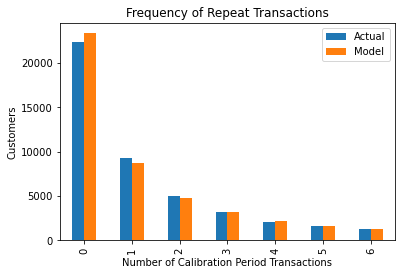

In [21]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(dispatcher_nbd['nbd_android_fb_old'])

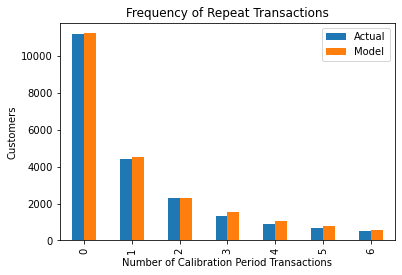

In [22]:
plot_period_transactions(dispatcher_nbd['nbd_android_fb_new'])

In [23]:
dispatcher_nbd

{'nbd_android_fb': <lifetimes.ParetoNBDFitter: fitted with 81029 subjects, alpha: 3.57, beta: 11.88, r: 0.63, s: 0.89>,
 'nbd_android_google': <lifetimes.ParetoNBDFitter: fitted with 65076 subjects, alpha: 3.34, beta: 17.24, r: 0.54, s: 0.96>,
 'nbd_android_restricted': <lifetimes.ParetoNBDFitter: fitted with 3864 subjects, alpha: 3.12, beta: 11.60, r: 0.64, s: 0.84>,
 'nbd_android_unity': <lifetimes.ParetoNBDFitter: fitted with 40245 subjects, alpha: 3.55, beta: 11.24, r: 0.70, s: 0.80>,
 'nbd_android_organic': <lifetimes.ParetoNBDFitter: fitted with 86123 subjects, alpha: 2.92, beta: 46.04, r: 0.45, s: 2.10>,
 'nbd_ios_applovin': <lifetimes.ParetoNBDFitter: fitted with 1833 subjects, alpha: 3.46, beta: 8.26, r: 0.47, s: 0.65>,
 'nbd_ios_fb': <lifetimes.ParetoNBDFitter: fitted with 143119 subjects, alpha: 3.20, beta: 6.22, r: 0.68, s: 0.57>,
 'nbd_ios_google': <lifetimes.ParetoNBDFitter: fitted with 43857 subjects, alpha: 2.67, beta: 12.25, r: 0.64, s: 0.53>,
 'nbd_ios_restricted': <l

## Train Beta Geometric/Negative Binomial Distribution model

In [21]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.generate_data import beta_geometric_nbd_model
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

def fit_bg_model(training_data, media_dict):
    
    bg_ios_fb = BetaGeoFitter(penalizer_coef=0.0)
    bg_ios_google = BetaGeoFitter(penalizer_coef=0.0)
    bg_ios_restricted = BetaGeoFitter(penalizer_coef=0.0)
    bg_ios_unity = BetaGeoFitter(penalizer_coef=0.0)
    bg_ios_applovin = BetaGeoFitter(penalizer_coef=0.0)
    bg_ios_organic = BetaGeoFitter(penalizer_coef=0.0)
    
    bg_android_fb = BetaGeoFitter(penalizer_coef=0.0)
    bg_android_google = BetaGeoFitter(penalizer_coef=0.0)
    bg_android_restricted = BetaGeoFitter(penalizer_coef=0.0)
    bg_android_unity = BetaGeoFitter(penalizer_coef=0.0)
    bg_android_organic = BetaGeoFitter(penalizer_coef=0.0)
    
    dispatcher = {'bg_android_fb':bg_android_fb, 
                  'bg_android_google':bg_android_google, 
                  'bg_android_restricted':bg_android_restricted,
                  'bg_android_unity':bg_android_unity,
                  'bg_android_organic':bg_android_organic,
                  'bg_ios_applovin':bg_ios_applovin, 
                  'bg_ios_fb':bg_ios_fb, 
                  'bg_ios_google':bg_ios_google,
                  'bg_ios_restricted':bg_ios_restricted,
                  "bg_ios_unity":bg_ios_unity, 
                  'bg_ios_organic':bg_ios_organic}
    
    # fit model for ios and andriod
    for i in ['ios', 'android']:
        for j in media_dict:
            
            # check applovin in android 
            if (i == 'android') & (j == 'applovin'):
                continue 
            else:  
                print("Training nbd model for {platform} {media_source} media source...".format(platform = i, media_source = j))
                dt_ = training_data[(training_data['platform']==i) & 
                                    (training_data['media_source']==media_dict[j])]
                bg_predict = dispatcher['bg_{platform}_{source}'.format(platform=i, source=j)]
                
                bg_predict.fit(dt_['frequency'], dt_['recency'],  dt_['T'])
                
    return dispatcher

def predict_bg_future_transactions(training_data, bg_models_dict, media_dict, observation_date, days=180):

    dt_all = pd.DataFrame()
    for i in ['ios', 'android']:
        for j in media_dict:
            
            # check if function exist in dictionary
            if 'bg_{platform}_{source}'.format(platform=i, source=j) not in bg_models_dict:
                continue        
            else:
                print("Predicting future transactios for {platform} {media_source} media source...".format(platform = i, media_source = j))
                
                dt_ = training_data[(training_data['platform']==i) & (training_data['media_source']==media_dict[j])]
                dt_period = pd.DataFrame() 
                bg_predict = bg_models_dict['bg_{platform}_{source}'.format(platform=i, source=j)]
            
                for k in range(1,days+1):
                    # print("Predicting transactions on {day} out of {period} days...".format(day=k, period=days))
                    dt_['period'] = k
                    dt_['cum_predicted_purchases_number'] = bg_predict.conditional_expected_number_of_purchases_up_to_time(dt_['period'], 
                                                                                                                   dt_['frequency'],
                                                                                                                   dt_['recency'],
                                                                                                                   dt_['T']).round(decimals=0)
                    dt_period = pd.concat([dt_period, dt_])
                    
            # dt_period_android = dt_period_android.reset_index()    
            dt_period = dt_period.sort_values(['appsflyer_id', 'period'], ascending=[True, True])
            dt_period['prev_value'] = dt_period.groupby('appsflyer_id')['cum_predicted_purchases_number'].shift()
            dt_period['prev_value'].fillna(0, inplace=True)
            dt_period['purchase'] = dt_period['cum_predicted_purchases_number'] - dt_period['prev_value']
        
            # leave rows with purchase
            dt_period = dt_period[dt_period['purchase'] == 1]
            dt_period.drop(['cum_predicted_purchases_number', 'prev_value'], inplace=True, axis=1)
            print(i, j, len(dt_period))
            
            # recovery of future purchase date
            dt_period['max_date'] = observation_date
            dt_period['predicted_date'] = dt_period['max_date'] + pd.to_timedelta(pd.np.ceil(dt_period['period']), unit="D") 
        
            # add average purchase to predicted data   
            dt_all = pd.concat([dt_period, dt_all])

    dt_all.drop(['frequency', 'recency', 'T', 'period', 'max_date'], inplace=True, axis=1)
    return dt_all

In [ ]:
# future_transactions_bg.to_csv('future_transactions_bg.csv')
# future_transactions.to_csv('future_transactions.csv')

# training_agg.to_csv('training_agg.csv')
# training_dt.to_csv('training_dt.csv')
# transactions_dt.to_csv('transactions_dt.csv')

# test_training_dt.to_csv('test_training_dt.csv') 
# test_transactions_dt.to_csv('test_transactions_dt.csv') 

In [59]:
dispatcher_bg

{'bg_android_fb': <lifetimes.BetaGeoFitter: fitted with 68506 subjects, a: 0.65, alpha: 1.09, b: 2.11, r: 0.24>,
 'bg_android_google': <lifetimes.BetaGeoFitter: fitted with 53918 subjects, a: 0.50, alpha: 1.36, b: 2.01, r: 0.28>,
 'bg_android_restricted': <lifetimes.BetaGeoFitter: fitted with 3187 subjects, a: 0.63, alpha: 1.06, b: 2.35, r: 0.26>,
 'bg_android_unity': <lifetimes.BetaGeoFitter: fitted with 33067 subjects, a: 0.53, alpha: 1.15, b: 2.06, r: 0.28>,
 'bg_android_organic': <lifetimes.BetaGeoFitter: fitted with 70810 subjects, a: 0.52, alpha: 1.12, b: 1.58, r: 0.23>,
 'bg_ios_applovin': <lifetimes.BetaGeoFitter: fitted with 1832 subjects, a: 0.49, alpha: 1.03, b: 1.21, r: 0.17>,
 'bg_ios_fb': <lifetimes.BetaGeoFitter: fitted with 137154 subjects, a: 0.49, alpha: 0.95, b: 1.96, r: 0.23>,
 'bg_ios_google': <lifetimes.BetaGeoFitter: fitted with 37439 subjects, a: 0.28, alpha: 1.23, b: 1.63, r: 0.36>,
 'bg_ios_restricted': <lifetimes.BetaGeoFitter: fitted with 4477 subjects, a: 0

In [3]:
### Read saved csvs

# future_transactions_bg = pd.read_csv('future_transactions_bg.csv')
# future_transactions = pd.read_csv('future_transactions.csv')

# training_agg = pd.read_csv('training_agg.csv')
# training_dt = pd.read_csv('training_dt.csv')
# transactions_dt = pd.read_csv('transactions_dt.csv')

# test_training_dt = pd.read_csv('test_training_dt.csv')
# test_transactions_dt = pd.read_csv('test_transactions_dt.csv')

In [ ]:
# future_transactions_bg = pd.read_csv('future_transactions_bg.csv')

In [23]:
def get_users_characteristics(): 
    client = bigquery.Client.from_service_account_json('./creds_coloring.json')
    # bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
    # bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./creds_coloring.json')
    project_id = 'goingtoclouds'
    
    # merge predicted purchases with media_source, campaign, adset ...
    sql = '''
    with cabinet_prefix as (
      select distinct a.campaign,  concat('(', RIGHT(CAST(b.act AS STRING), 4), ')') as act
          from (
            SELECT distinct campaign, campaign_id
            FROM `goingtoclouds.ltv.active_adsets` 
            where media_source = 'Facebook Ads') as a
          LEFT JOIN (
            SELECT distinct act, CAST(campaign_name AS STRING) as campaign_id
            FROM `goingtoclouds.hc_compendium.timezone_compendium`) AS b
          ON a.campaign_id = b.campaign_id
          where act is not null
    )

    select distinct appsflyer_id, customer_user_id as user_id, date(first_cohort_date) as first_cohort_date, 
        platform, media_source, 
        if(cabinet_prefix.act is not null, concat(cabinet_prefix.act, ' ', a.campaign), a.campaign) as campaign,
        adset, country_code, country_name
    from (
        select distinct appsflyer_id, ifnull(customer_user_id, 0) as customer_user_id, platform, 
            ifnull(replace(lower(media_source), ' ', '_'), 'organic') as media_source, 
            if(media_source='restricted', 'Null', campaign) as campaign, 
            if(media_source = 'googleadwords_int', campaign, 
                    if(media_source = 'unityads_int', concat(campaign, '-', adset),
                        if(media_source = 'restricted', 'Null', adset))) as adset, 
            ifnull(country_code, 'Null') as country_code, 
            ifnull(country_name, 'Null') as country_name,
            install_day as first_cohort_date
        from `goingtoclouds.aggregated_data.aggregated_installs_v3`
        left join `goingtoclouds.aggregated_data.codelist`
        on `goingtoclouds.aggregated_data.aggregated_installs_v3`.country_code=`goingtoclouds.aggregated_data.codelist`.eurostat
    ) as a
    left join cabinet_prefix
    on a.campaign=cabinet_prefix.campaign
    '''    
    user_ids = client.query(sql, project=project_id).to_dataframe()
    return user_ids


def clean_prepared_data(actual_data, predicted_data, users_characteristics):
    client = bigquery.Client.from_service_account_json('./creds_coloring.json')
    project_id = 'goingtoclouds'
    
    actual_data = actual_data.merge(users_characteristics, on=['appsflyer_id'], how='left')
    predicted_data = predicted_data.merge(users_characteristics, on=['appsflyer_id'], how='left')
    
    actual_data.media_source_y[actual_data['media_source_y'].isna()] = actual_data.media_source_x[actual_data['media_source_y'].isna()]
    predicted_data.media_source_y[predicted_data['media_source_y'].isna()] = predicted_data.media_source_x[predicted_data['media_source_y'].isna()]    
    actual_data.platform_y[actual_data['platform_y'].isna()] = actual_data.platform_x[actual_data['platform_y'].isna()]
    predicted_data.platform_y[predicted_data['platform_y'].isna()] = predicted_data.platform_x[predicted_data['platform_y'].isna()]
        
    actual_data.drop(['media_source_x', 'platform_x', 'user_id_x'], axis=1, inplace = True)
    actual_data.rename(columns={"media_source_y":'media_source', "platform_y":'platform', 
                                'user_id_y':'user_id'}, inplace=True)   
    predicted_data.drop(['media_source_x', 'platform_x'], axis=1, inplace = True)
    predicted_data.rename(columns={"media_source_y":'media_source', "platform_y":'platform'}, inplace=True)
    
    actual_data['label'] = 'actual_data'
    predicted_data['label'] = "predicted_data"
       
    predicted_data.rename(columns={'monetary_value':'value', 'predicted_date':'transaction_date'}, inplace=True)
    predicted_data.drop(['purchase'], inplace=True, axis=1)
    actual_data.rename(columns={'sales':'value'}, inplace=True)
    all_data = pd.concat([actual_data, predicted_data])
        
    print('Retrieve users CPI')
    sql = '''select appsflyer_id, sum(cpi) as cpi
    from `goingtoclouds.aggregated_data.roas_v4` 
    group by appsflyer_id
    '''
    cpi_dt = client.query(sql, project=project_id).to_dataframe()
    
    all_data = all_data.merge(cpi_dt, on=['appsflyer_id'], how='left')    
    all_data['cpi'].fillna("0", inplace=True)
    all_data['cpi'] = all_data['cpi'].astype(float)
    
    all_data['predicted_rev'] = all_data.groupby(['appsflyer_id', 'platform']).value.transform('sum')
    all_data['actual_rev'] = all_data[all_data.label=='actual_data'].groupby(['appsflyer_id', 'platform']).value.transform('sum')
    all_data['actual_rev'] = all_data.groupby(['appsflyer_id', 'platform']).actual_rev.transform(np.nanmax)
    
    all_data['actual_roas'] = all_data['actual_rev']/all_data['cpi'] 
    all_data['predicted_roas'] = all_data['predicted_rev']/all_data['cpi'] 
    
    all_data.predicted_roas[all_data['cpi']== 0] = all_data.predicted_rev[all_data['cpi']== 0]
    all_data.actual_roas[all_data['cpi']== 0] = all_data.actual_rev[all_data['cpi']== 0] 
    all_data.drop(['actual_rev', 'predicted_rev'], inplace=True, axis=1)
    
    all_data = all_data.sort_values(by=['appsflyer_id', 'platform', 'transaction_date'])        
    all_data['cumulative_revenue'] = all_data.groupby(['appsflyer_id', 'platform']).value.cumsum()
    
    all_data['country_code'].fillna("Null", inplace=True)
    all_data['country_name'].fillna("Null", inplace=True) 
    all_data['campaign'].fillna("Null", inplace=True)
    all_data['adset'].fillna("Null", inplace=True)   
    all_data['transaction_date'] = pd.to_datetime(all_data.transaction_date).dt.date
    # all_data['transaction_date'] = all_data.transaction_date.astype(dtype='datetime64[D]')
    
    return all_data

In [24]:
user_ids = get_users_characteristics()

In [25]:
nbd_data = clean_prepared_data(control_transactions_dt[['appsflyer_id', 'user_id', 'platform', 'media_source','transaction_date', 
                                                     'sales']], 
                               future_transactions[['appsflyer_id', 'platform', 'media_source', 'monetary_value', 'purchase', 
                                                    'predicted_date']], user_ids) 
# bg_data = clean_prepared_data(test_transactions_dt[['appsflyer_id', 'user_id', 'platform', 'media_source','transaction_date', 
#                                                      'sales']], 
#                               future_transactions_bg[['appsflyer_id', 'platform', 'media_source', 'monetary_value', 'purchase', 
#                                                     'predicted_date']], user_ids)  

Retrieve users CPI


In [26]:
actual_data = test_training_dt.copy()
actual_data = actual_data[(pd.to_datetime(actual_data.transaction_date).dt.date>=dt.date(2021, 2, 2))][["appsflyer_id", "transaction_date", "sales"]]
actual_data = actual_data.merge(user_ids, how='left', on='appsflyer_id')
actual_data = actual_data.groupby(['appsflyer_id', 'transaction_date', "user_id", "first_cohort_date", 
                                   "platform", "media_source", "campaign", "adset", "country_code", 
                                   "country_name"]).sales.sum().reset_index()
actual_data_agg = actual_data.groupby(['platform', 'media_source', 'campaign','adset']).agg({
    'first_cohort_date':'min', 'transaction_date':'count', 'sales':'sum'}).reset_index()

In [27]:
nbd_data = nbd_data[nbd_data.transaction_date <= dt.date(2021, 4, 19)]
nbd_data_agg = nbd_data.groupby(['platform', 'media_source', 'campaign', 
                                 'adset']).agg({'first_cohort_date':'min', 'transaction_date':'count',
                                                'value':'sum'}).reset_index()

# bg_data = bg_data[bg_data.transaction_date <= dt.date(2021, 3, 23)]
# nbd_data = nbd_data[nbd_data.transaction_date <= dt.date(2021, 3, 23)]

In [35]:
# Считаем MAE числа транзакций на уровне пользователя 

transactions_user_fact = actual_data.groupby(["platform", "media_source", 'appsflyer_id']).transaction_date.nunique().reset_index()
transactions_user_predict = nbd_data[nbd_data.transaction_date>=dt.date(2021, 2, 2)].groupby(["platform", "media_source", 
                                                                        'appsflyer_id']).transaction_date.nunique().reset_index()

transactions_user_fact.rename(columns={"transaction_date":'transactions_fact'}, inplace=True)
transactions_user_predict.rename(columns={"transaction_date":'transactions_pred'}, inplace=True)

transactions_user_predict = transactions_user_predict.merge(transactions_user_fact, 
                                                            on =["appsflyer_id", "platform", "media_source"], how='outer')
transactions_user_predict.fillna(0, inplace=True)
transactions_user_predict['diff_abs'] = abs(transactions_user_predict["transactions_pred"]-
                                        transactions_user_predict["transactions_fact"])
transactions_user_predict['diffs'] = transactions_user_predict["transactions_pred"]-transactions_user_predict["transactions_fact"]


In [37]:
transactions_user_predict.groupby(["platform", "media_source"])[['diff_abs']].mean().reset_index()

platform       media_source  diff_abs
0   android       facebook_ads  6.236180
1   android  googleadwords_int  5.691085
2   android            organic  5.988790
3   android         restricted  7.502343
4   android       unityads_int  6.251011
5       ios       applovin_int  6.191057
6       ios       facebook_ads  7.613332
7       ios  googleadwords_int  8.257891
8       ios            organic  7.131248
9       ios         restricted  8.659701
10      ios       unityads_int  5.872486

In [38]:
transactions_user_predict.groupby(["platform", "media_source"])[['diffs']].mean().reset_index()

platform       media_source     diffs
0   android       facebook_ads  1.446951
1   android  googleadwords_int  1.310066
2   android            organic  1.471762
3   android         restricted  1.779756
4   android       unityads_int  2.037489
5       ios       applovin_int  1.231707
6       ios       facebook_ads  1.812780
7       ios  googleadwords_int  0.320172
8       ios            organic  1.700969
9       ios         restricted  1.159204
10      ios       unityads_int  0.226923

In [39]:
# Считаем MAE числа транзакций для старых и новых пользователей

actual_data['user_type'] = np.where(actual_data.first_cohort_date<dt.date(2020, 11, 3),'old', "new")
nbd_data['user_type'] = np.where(nbd_data.first_cohort_date<dt.date(2020, 11, 3),'old', "new")

transactions_user_type_fact = actual_data.groupby(["platform", "media_source", 'appsflyer_id',
                                             'user_type']).transaction_date.nunique().reset_index()
transactions_user_type_predict = nbd_data[nbd_data.transaction_date>=dt.date(2021, 2, 2)].groupby(["platform", "media_source", 
                                                                        'appsflyer_id', 'user_type']).transaction_date.nunique().reset_index()

transactions_user_type_fact.rename(columns={"transaction_date":'transactions_fact'}, inplace=True)
transactions_user_type_predict.rename(columns={"transaction_date":'transactions_pred'}, inplace=True)

transactions_user_type_predict = transactions_user_type_predict.merge(transactions_user_type_fact, 
                                                            on =["appsflyer_id", "platform", "media_source", 'user_type'], 
                                                                      how='outer')
transactions_user_type_predict.fillna(0, inplace=True)
transactions_user_type_predict['diff_abs'] = abs(transactions_user_type_predict["transactions_pred"]-
                                        transactions_user_type_predict["transactions_fact"])
transactions_user_type_predict['diffs'] = transactions_user_type_predict["transactions_pred"]-transactions_user_type_predict["transactions_fact"]


In [40]:
transactions_user_type_predict.groupby(['user_type', "platform", "media_source"])[['diff_abs']].mean().reset_index()

user_type platform       media_source   diff_abs
0        new  android       facebook_ads   6.311894
1        new  android  googleadwords_int   5.054849
2        new  android            organic   5.939136
3        new  android         restricted   7.581186
4        new  android       unityads_int   5.864622
5        new      ios       facebook_ads   7.852567
6        new      ios  googleadwords_int   7.635076
7        new      ios            organic   7.078758
8        new      ios         restricted  10.017316
9        new      ios       unityads_int   5.356992
10       old  android       facebook_ads   6.076771
11       old  android  googleadwords_int   7.120110
12       old  android            organic   6.380841
13       old  android         restricted   7.292096
14       old  android       unityads_int   6.895728
15       old      ios       applovin_int   6.191057
16       old      ios       facebook_ads   7.528423
17       old      ios  googleadwords_int   8.967819
18       old      ios            organic   7.193826
19       old      ios         restricted   8.254522
20       old      ios       unityads_int   6.829243

In [41]:
transactions_user_type_predict.groupby(['user_type', "platform", "media_source"])[['diffs']].mean().reset_index()

user_type platform       media_source     diffs
0        new  android       facebook_ads  1.074012
1        new  android  googleadwords_int  0.579202
2        new  android            organic  1.315852
3        new  android         restricted  1.418814
4        new  android       unityads_int  1.552542
5        new      ios       facebook_ads  1.244764
6        new      ios  googleadwords_int  1.480247
7        new      ios            organic  1.283794
8        new      ios         restricted  3.177489
9        new      ios       unityads_int  0.407584
10       old  android       facebook_ads  2.232140
11       old  android  googleadwords_int  2.951631
12       old  android            organic  2.737539
13       old  android         restricted  2.742268
14       old  android       unityads_int  2.846658
15       old      ios       applovin_int  1.231707
16       old      ios       facebook_ads  2.014381
17       old      ios  googleadwords_int -1.002161
18       old      ios            organic  2.199819
19       old      ios         restricted  0.556848
20       old      ios       unityads_int -0.108384

In [42]:
# Считаем MAE числа транзакций по кампаниям
transactions_user_type_fact = actual_data.groupby(["platform", "media_source", 'appsflyer_id', 
                                                   'user_type', 'campaign', 'adset']).transaction_date.nunique().reset_index()
transactions_user_type_predict = nbd_data[nbd_data.transaction_date>=dt.date(2021, 2, 2)].groupby(["platform", "media_source", 
                                                                        'appsflyer_id', 'user_type', 'campaign', 'adset']).transaction_date.nunique().reset_index()

transactions_user_type_fact.rename(columns={"transaction_date":'transactions_fact'}, inplace=True)
transactions_user_type_predict.rename(columns={"transaction_date":'transactions_pred'}, inplace=True)

transactions_user_type_predict = transactions_user_type_predict.merge(transactions_user_type_fact, 
                                                                      on =["appsflyer_id", "platform", "media_source", 'user_type', 
                                                                           'campaign', 'adset'], 
                                                                      how='outer')
transactions_user_type_predict.fillna(0, inplace=True)

campaign = transactions_user_type_predict.groupby(["platform", "media_source", "campaign"]).agg({"transactions_pred":'sum', 
                                                                                      "transactions_fact":'sum'}).reset_index()
campaign['diff_abs'] = abs(campaign["transactions_pred"]-campaign["transactions_fact"])
campaign['diffs'] = campaign["transactions_pred"]-campaign["transactions_fact"]

In [43]:
campaign.groupby(["platform", "media_source"])[['diff_abs']].mean().reset_index()

platform       media_source      diff_abs
0   android       facebook_ads   1023.068966
1   android  googleadwords_int   2384.909091
2   android            organic  34530.000000
3   android         restricted   1899.000000
4   android       unityads_int   6426.750000
5       ios       applovin_int    303.000000
6       ios       facebook_ads    320.065089
7       ios  googleadwords_int    636.441176
8       ios            organic  33015.000000
9       ios         restricted   1165.000000
10      ios       unityads_int    364.500000

In [44]:
campaign.groupby(["platform", "media_source"])[['diffs']].mean().reset_index()

platform       media_source         diffs
0   android       facebook_ads   1017.206897
1   android  googleadwords_int   2381.818182
2   android            organic  34530.000000
3   android         restricted   1899.000000
4   android       unityads_int   6426.750000
5       ios       applovin_int    303.000000
6       ios       facebook_ads    299.130178
7       ios  googleadwords_int    177.205882
8       ios            organic  33015.000000
9       ios         restricted   1165.000000
10      ios       unityads_int    146.269231

In [45]:
# Считаем MAE числа транзакций на уровне пользователя 

value_user_fact = actual_data.groupby(["platform", "media_source", 'appsflyer_id'])[["sales"]].sum().reset_index()
value_user_predict = nbd_data[nbd_data.transaction_date>=dt.date(2021, 2, 2)].groupby(["platform", "media_source", 
                                                                                       'appsflyer_id'])[["value"]].sum().reset_index()

value_user_fact.rename(columns={"sales":'value_fact'}, inplace=True)
value_user_predict.rename(columns={"value":'value_pred'}, inplace=True)

value_user_predict = value_user_predict.merge(value_user_fact, on =["appsflyer_id", "platform", "media_source"], how='outer')
value_user_predict.fillna(0, inplace=True)
value_user_predict['diff_abs'] = abs(value_user_predict["value_pred"]- value_user_predict["value_fact"])
value_user_predict['diffs'] = value_user_predict["value_pred"]-value_user_predict["value_fact"]

In [46]:
value_user_predict.groupby(["platform", "media_source"])[['diff_abs']].mean().reset_index()

platform       media_source  diff_abs
0   android       facebook_ads  1.399196
1   android  googleadwords_int  1.254275
2   android            organic  0.633448
3   android         restricted  1.570326
4   android       unityads_int  1.386158
5       ios       applovin_int  1.093892
6       ios       facebook_ads  1.227077
7       ios  googleadwords_int  1.354980
8       ios            organic  0.991672
9       ios         restricted  1.236211
10      ios       unityads_int  1.010100

In [47]:
value_user_predict.groupby(["platform", "media_source"])[['diffs']].mean().reset_index()

platform       media_source     diffs
0   android       facebook_ads  0.298962
1   android  googleadwords_int  0.226745
2   android            organic  0.091854
3   android         restricted  0.473266
4   android       unityads_int  0.353471
5       ios       applovin_int  0.134471
6       ios       facebook_ads  0.207537
7       ios  googleadwords_int  0.086601
8       ios            organic  0.201226
9       ios         restricted  0.183229
10      ios       unityads_int  0.062978

In [48]:
# Считаем MAE денег на уровне кампании

value_user_fact = actual_data.groupby(["platform", "media_source", 'appsflyer_id', 'campaign', 
                                       'adset'])[["sales"]].sum().reset_index()
value_user_predict = nbd_data[nbd_data.transaction_date>=dt.date(2021, 2, 2)].groupby(["platform", "media_source", 'appsflyer_id', 'campaign', 
                                                                                       'adset'])[["value"]].sum().reset_index()

value_user_fact.rename(columns={"sales":'value_fact'}, inplace=True)
value_user_predict.rename(columns={"value":'value_pred'}, inplace=True)

value_user_predict = value_user_predict.merge(value_user_fact, on =["appsflyer_id", "platform", "media_source", 'campaign', 
                                       'adset'], how='outer')
value_user_predict.fillna(0, inplace=True)

value_user_predict = value_user_predict.groupby(["platform", "media_source", "campaign"]).agg({"value_pred":'sum', 
                                                                                               "value_fact":'sum'}).reset_index()
value_user_predict['diff_abs'] = abs(value_user_predict["value_pred"]-value_user_predict["value_fact"])
value_user_predict['diffs'] = value_user_predict["value_pred"]-value_user_predict["value_fact"]

In [49]:
value_user_predict.groupby(["platform", "media_source"])[['diff_abs']].mean().reset_index()

platform       media_source     diff_abs
0   android       facebook_ads   211.126828
1   android  googleadwords_int   412.742566
2   android            organic  2154.977654
3   android         restricted   504.974362
4   android       unityads_int  1114.935554
5       ios       applovin_int    33.079885
6       ios       facebook_ads    39.891596
7       ios  googleadwords_int   133.957098
8       ios            organic  3904.992243
9       ios         restricted   184.144781
10      ios       unityads_int    90.340316

In [50]:
value_user_predict.groupby(["platform", "media_source"])[['diffs']].mean().reset_index()

platform       media_source        diffs
0   android       facebook_ads   210.170142
1   android  googleadwords_int   412.243216
2   android            organic  2154.977654
3   android         restricted   504.974362
4   android       unityads_int  1114.935554
5       ios       applovin_int    33.079885
6       ios       facebook_ads    34.246063
7       ios  googleadwords_int    47.931295
8       ios            organic  3904.992243
9       ios         restricted   184.144781
10      ios       unityads_int    40.594068

In [40]:
bg_data_agg = bg_data[bg_data.label=='predicted_data'].groupby(['platform', 'media_source', 'campaign', 
                                                                'adset']).agg({'first_cohort_date':'min', 
                                                                               'transaction_date':'count',
                                                                               'value':'sum'}).reset_index()
nbd_data_agg = nbd_data[nbd_data.label=='predicted_data'].groupby(['platform', 'media_source', 'campaign', 
                                                                   'adset']).agg({'first_cohort_date':'min', 
                                                                               'transaction_date':'count',
                                                                               'value':'sum'}).reset_index()

In [46]:
actual_data = actual_data.merge(user_ids, how='left', on='appsflyer_id')
actual_data_agg = actual_data.groupby(['platform', 'media_source', 'campaign','adset']).agg({
    'first_cohort_date':'min', 'transaction_date':'count', 'sales':'sum'}).reset_index()


In [48]:
# actual_data_agg.to_csv('actual_data_agg.csv')
# nbd_data_agg.to_csv('nbd_data_agg.csv')
# bg_data_agg.to_csv('bg_data_agg.csv')

In [51]:
print(len(actual_data_agg), len(nbd_data_agg), len(bg_data_agg))

1041 1079 1094


In [54]:
bg_data_agg = bg_data_agg.merge(nbd_data_agg, how='outer', on=['platform', 'media_source', 'campaign','adset'])


bg_data_agg.rename(columns={"first_cohort_date_x":'bg_first_cohort_date', "first_cohort_date_y":'nbd_first_cohort_date', 
                            "transaction_date_x":'bg_transactions', "transaction_date_y":'nbd_transactions',
                            'value_x':'bg_value', 'value_y':'nbd_value'}, inplace=True) 
bg_data_agg

platform  media_source                    campaign  \
0     android  facebook_ads  (1180) HC|AAA|US|inst|auto   
1     android  facebook_ads      (1180) HC|Android|test   
2     android  facebook_ads      (1180) HC|Android|test   
3     android  facebook_ads      (1180) HC|Android|test   
4     android  facebook_ads      (1180) HC|Android|test   
...       ...           ...                         ...   
1093      ios  unityads_int                 HC|reten|US   
1094      ios  facebook_ads          (1180) HC|US|11.06   
1095      ios  facebook_ads         (1180) HC|lal 08.08   
1096      ios  facebook_ads     (1180) HC|lal|US| 08.08   
1097      ios  facebook_ads     (1180) HC|lal|US| 08.08   

                          adset bg_first_cohort_date  bg_transactions  \
0           HC|AAA|US|inst|auto           2020-10-28              3.0   
1          HC|US|test|45 - Copy           2020-08-26             48.0   
2          HC|US|test|47 - Copy           2020-08-27              4.0   
3          HC|US|test|48 - Copy           2020-08-26              5.0   
4          HC|US|test|49 - Copy           2020-08-26              4.0   
...                         ...                  ...              ...   
1093           HC|reten|US-sc48           2020-08-25             44.0   
1094   HC|lal 5% time180|US|18+                  NaN              NaN   
1095  HC|lal 5% time 90 |US|13+                  NaN              NaN   
1096  HC|lal 1% installs|US|13+                  NaN              NaN   
1097  HC|lal 5% time 90 |US|13+                  NaN              NaN   

       bg_value nbd_first_cohort_date  nbd_transactions  nbd_value  
0      0.241950            2020-10-28               3.0   0.241950  
1     12.823510            2020-08-26              46.0  12.294098  
2      1.748693            2020-08-27               4.0   1.748693  
3      1.301546            2020-08-26               6.0   1.604912  
4      0.540700            2020-08-27               4.0   0.629058  
...         ...                   ...               ...        ...  
1093  15.579069            2020-08-25              42.0  15.047412  
1094        NaN            2020-06-21               1.0   0.107083  
1095        NaN            2020-08-10               1.0   0.097706  
1096        NaN            2020-08-16               1.0   0.312775  
1097        NaN            2020-08-15               1.0   0.054437  

[1098 rows x 10 columns]

In [56]:
bg_data_agg.merge(actual_data_agg, how='outer', on=['platform', 'media_source', 'campaign','adset']).to_csv("agg_data.csv")